In [1]:
from sklearn.svm import SVC
from util import info
import numpy as np
import os
from sklearn.utils.fixes import loguniform
# from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import LeaveOneOut
# from skopt import BayesSearchCV
from skopt import Optimizer
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

from joblib import Parallel, delayed

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.animation as animation
plt.style.use(['dark_background'])


import warnings
warnings.filterwarnings("ignore")

In [5]:

xn = np.linspace(-.25,1.0,200)
xnn = xn[7:-10]

data = np.load(r"C:\Users\zfj\data\081122B\func\spots_smooth.npy")
data = np.moveaxis(data[:,:,7:-10],0,1)
# fdata = data.reshape(data.shape[0],-1)

labels = np.load(r"C:\Users\zfj\data\081122B\func\spots_labels.npy")
ue = np.array([
[-24.74181249, -24.74181249, -16.49454166, -16.49454166, -16.49454166,
   -8.24727083,  -8.24727083,   0.,           0.,           0.,
    8.24727083,   8.24727083,  16.49454166,  16.49454166,  16.49454166,
   24.74181249,  24.74181249],
[-14.2846921,   14.2846921,  -28.56938421,   0.,          28.56938421,
  -14.2846921,   14.2846921,  -28.56938421,   0.,          28.56938421,
  -14.2846921,   14.2846921,  -28.56938421,   0.,          28.56938421,
  -14.2846921,   14.2846921 ]]).T
  
  
best_c = [ 55,  18,  60,  46,  20,  83,]
worst_c = [67, 114, 136, 39, 128, ]

In [32]:
from sklearn.svm import LinearSVR
from sklearn.multioutput import RegressorChain
from sklearn.decomposition import PCA

def get_info(fdata, flabels, fue, ncomps):
  
  cv = KFold(10, shuffle=True)
  svm_i = info.MI(flabels, ndims=2)
  y_hats = np.empty((len(flabels),2))
  for train, test in cv.split(fdata):
        mms = MinMaxScaler().fit(fdata[train])
        mod = RegressorChain(LinearSVR(C=1.0))

        # if fdata.shape[1] < 40:
        #   mod.fit(mms.transform(fdata[train]), fue[flabels[train],:])
        #   y_hats[test,:] = mod.predict(mms.transform(fdata[test]))
        # else:
        pca = PCA(ncomps, whiten=True)
        comps = pca.fit_transform(mms.transform(fdata[train]))
        
        mod.fit(comps, fue[flabels[train],:])
        y_hats[test,:] = mod.predict(pca.transform(mms.transform(fdata[test])))

  MI = svm_i.QE(y_hats)
  print(fdata.shape[1]//data.shape[1], MI)
  return MI, pca


# MI_c = np.zeros(200)
for i in range(1,40):
  MI_c[i],pcs = get_info(data[:,best_c,30:60].reshape(data.shape[0],-1), labels, ue, i)


# plt.plot(np.nan)
# plt.plot(xnn[40:],MI_t)
# plt.gca().set_facecolor([0,0,0,0])
# plt.ylim(-.25,3.25)
# plt.xlim(-.25,1)

# plt.xticks([])
# plt.yticks([])

# print(max(MI_t), max(MI_t)/np.log2(17), max(MI_t)/3.0)

# l = plt.legend(['Full population','Top 6 individual cells'],facecolor='inherit')

1 0.054124654927587536
1 0.25339881910694007
1 0.3493048009025919
1 0.3640081773664931
1 0.47978828095407183
1 0.3743437788411939
1 0.7985227962324456
1 1.1301725357922017
1 1.109315042078242
1 1.173225696712481
1 1.3651782578117104
1 1.214799524735129
1 1.3003553059897937
1 1.4959514198335346
1 1.7014865770922083
1 1.6151418303598184
1 1.5741522630142966
1 1.599520688430736
1 1.7033128012534684
1 1.6306476244421215
1 1.7771052357445307
1 1.8766952203363862
1 1.7452135082523585
1 1.7565165761943018
1 1.7695425706072159
1 1.775595116089456
1 1.6517625849660278
1 1.879665276669415
1 1.7710853920758762
1 1.7973353859105212
1 1.7706154837675934
1 1.7613270324925177
1 1.865478960619974
1 1.834567432757104
1 1.9179824285256586
1 1.7756653572155154
1 1.8911321338532552
1 1.8322049080068303
1 1.8889326201334653


[[62]] [[2.05234918]]


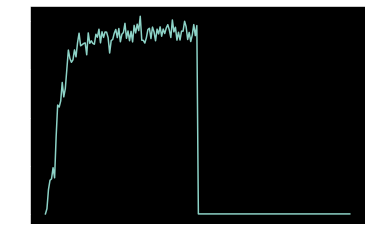

In [88]:
# plt.plot(pcs.explained_variance_ratio_)
# pcs.components_.shape, data[:,best_c,30:60].reshape(data.shape[0],-1).shape
plt.plot(MI_c)
print(np.argwhere(MI_c==MI_c.max()), MI_c[np.argwhere(MI_c==MI_c.max())])

In [94]:
def do_svm(fdata, flabels, fue, ncomps):
  cv = KFold(10, shuffle=True)
  y_hats = np.empty((len(flabels),2))
  for train, test in cv.split(fdata):
    mms = MinMaxScaler().fit(fdata[train])
    mod = RegressorChain(LinearSVR(C=1.0))

    # if fdata.shape[1] < 40:
    #   mod.fit(mms.transform(fdata[train]), fue[flabels[train],:])
    #   y_hats[test,:] = mod.predict(mms.transform(fdata[test]))
    # else:
    pca = PCA(ncomps, whiten=True)
    comps = pca.fit_transform(mms.transform(fdata[train]))
    
    mod.fit(comps, fue[flabels[train],:])
    y_hats[test,:] = mod.predict(pca.transform(mms.transform(fdata[test])))
  return y_hats, np.sqrt(((y_hats - fue[flabels])**2).sum(axis=1)).mean(axis=0)

y_hats,rms_e = do_svm(data[:,best_c,30:60].reshape(data.shape[0],-1), labels, ue, 62)


In [95]:
print(rms_e)

11.602698066228024


In [59]:
from sklearn.linear_model import ElasticNet

regr = ElasticNet(l1_ratio=.75, alpha=.01)

regr.fit(data[:,best_c,30:60].reshape(data.shape[0],-1), ue[labels])

ElasticNet(alpha=0.01, l1_ratio=0.75)

267
13.073667489007326


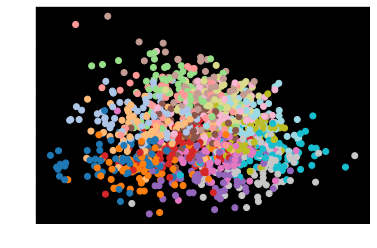

In [60]:
print(np.count_nonzero(regr.coef_))

plt.scatter(*regr.predict(data[:,best_c,30:60].reshape(data.shape[0],-1)).T, c=labels, cmap='tab20')

print(np.sqrt(((regr.predict(data[:,best_c,30:60].reshape(data.shape[0],-1)) - ue[labels])**2).sum(axis=1)).mean())


In [96]:

# alphas = np.flip(np.linspace(1e-7,1.0,25))
alphas = np.flip(np.logspace(1e-10,1e-6,50))

def do_en(fdata, fue, flabels, en, alpha):
  cv = KFold(10, shuffle=True)
  yhat = np.empty((fdata.shape[0], 2))
  nnz = np.empty(10, dtype=int)

  for i, (train, test) in enumerate(cv.split(data)):
    regr = ElasticNet(l1_ratio=en, alpha=alpha)
    regr.fit(fdata[train], fue[flabels[train]])
    yhat[test,:] = regr.predict(fdata[test])
    nnz[i] = np.count_nonzero(regr.coef_)

  return yhat, nnz
  
def do_fit(fdata, fue, flabels, en):
  cv = KFold(10, shuffle=True)
  yhat = np.empty((fdata.shape[0], len(alphas), 2))

  for train, test in cv.split(data):
    regr = ElasticNet(l1_ratio=en)
    for j in range(len(alphas)):
      regr.alpha = alphas[j]
      regr.fit(fdata[train], fue[flabels[train]])
      yhat[test,j,:] = regr.predict(fdata[test])
      regr.warm_start = True
  
  return np.sqrt(((yhat - fue[flabels,None])**2).sum(axis=2)).mean(axis=0)


ens = np.logspace(-3,0,25)


RMS = np.zeros((len(alphas), len(ens)))

for i in range(len(ens)):
  RMS[:,i] = do_fit(data[:,best_c,30:60].reshape(data.shape[0],-1), ue, labels, ens[i])

     


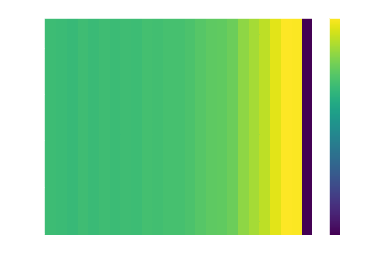

In [84]:
plt.pcolor(ens, alphas, RMS)
plt.ylabel('Lambda')
plt.xlabel('Alpha')
plt.xscale('log')

plt.colorbar()

In [129]:
alphas = [1e-1]

fdata = data[:,best_c,30:80].reshape(data.shape[0],-1)
print(do_fit(fdata, ue, labels, .25))
yhat, nnz = do_en(fdata, ue, labels, .99, alphas[0])



[11.64597289]


In [131]:
nnz,  (fdata.shape[1] * 2)

(array([82, 79, 77, 82, 82, 80, 80, 82, 82, 81]), 600)

In [137]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.multioutput import RegressorChain


RegressorChain(base_estimator=AdaBoostRegressor(base_estimator=ElasticNet(alpha=0.1,
                                                                          l1_ratio=0.99)),
               cv=10)

10.58531122259394

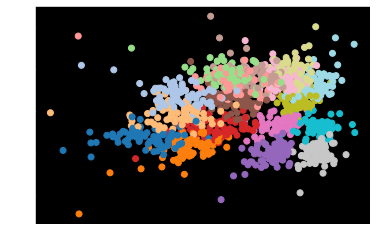

In [170]:
fdata = data.reshape(data.shape[0],-1)

regr = RegressorChain(AdaBoostRegressor(ElasticNet(alpha=1, l1_ratio=.25)), cv=10)
regr.fit(fdata, ue[labels])


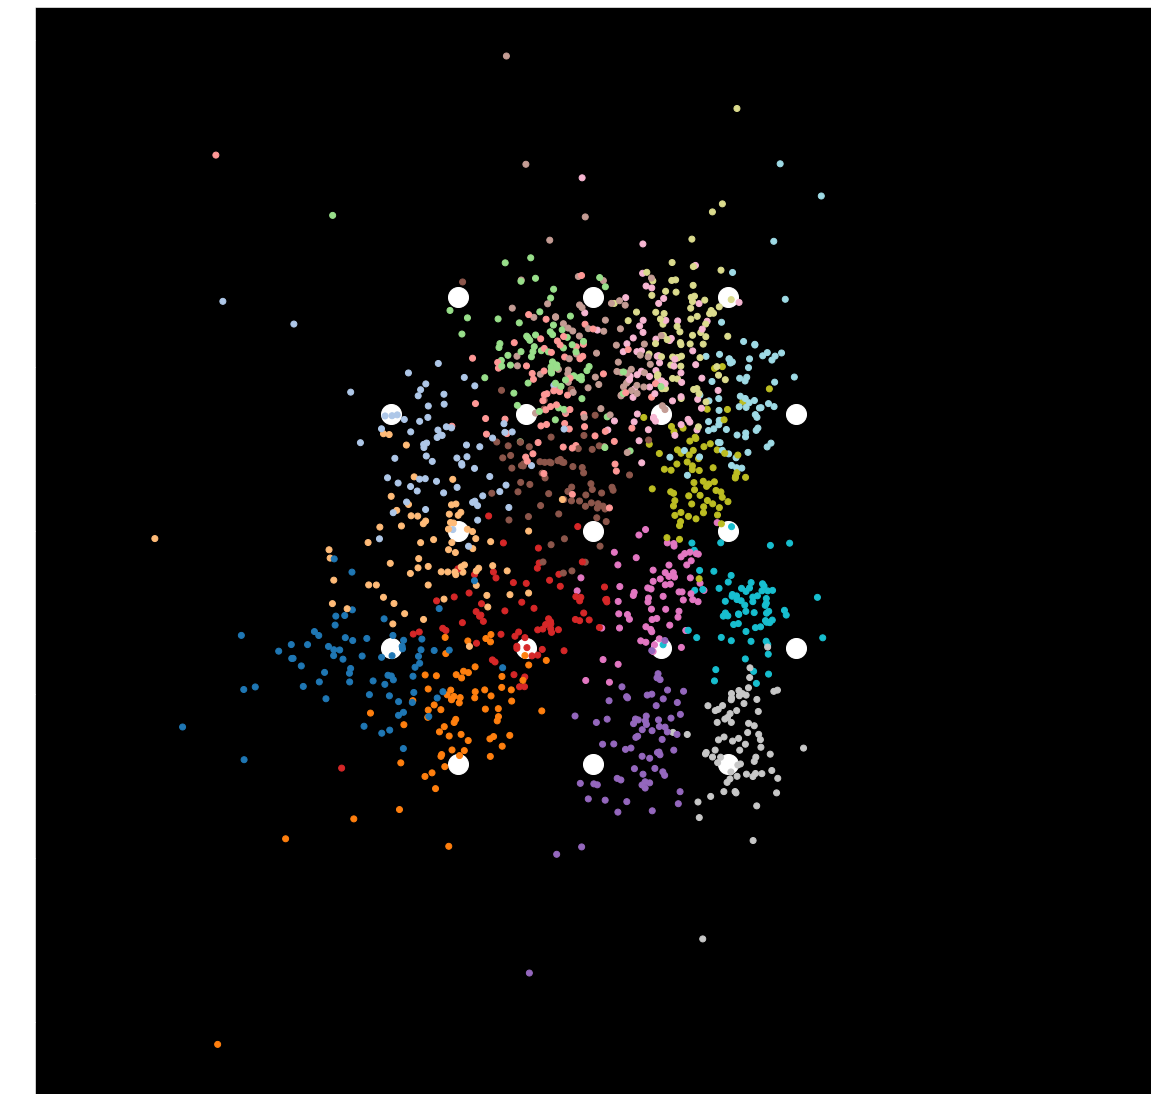

In [198]:
plt.figure(figsize=(20,20))
plt.scatter(ue[:,0], ue[:,1], s=400, color='white')
plt.scatter(*regr.predict(fdata).T * np.asarray((1.4583333333333333,1.2916666666666665,))[:,None], c = labels, cmap='tab20')
# print(np.sqrt(((regr.predict(fdata) - ue[labels])**2).sum(axis=1)).mean())
plt.axis('equal')
plt.xlim(-15,15)
plt.show()

In [171]:
print([[np.count_nonzero(b.coef_) for b in a.estimators_] for a in regr.estimators_])

print(fdata.shape)

[[496, 569, 695, 725, 757, 777, 824, 827, 784], [692, 729, 788, 824, 824, 825, 851, 818, 887, 893, 884, 891, 892, 940]]
(1222, 31110)


In [183]:
yhat = regr.predict(fdata)
yhat.shape

(1222, 2)

1.2916666666666665

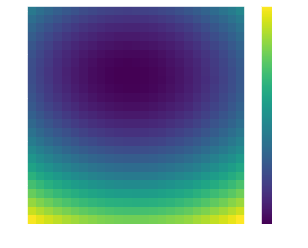

In [195]:
err = np.asarray([[np.sqrt(((yhat*np.asarray([k,j]) - ue[labels])**2).sum(axis=1)).mean() for k in np.linspace(1.0,2.0,25)] for j in np.linspace(1.0,2.0,25)])
plt.imshow(err)
plt.colorbar()
np.linspace(1.0,2.0,25)[7]
# (1.2916666666666665,1.4583333333333333)

In [203]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [324]:
x_train, x_test, y_train, y_test = train_test_split(np.moveaxis(data,-1,-2), ue[labels], test_size=0.2)

print([a.shape for a in (x_train, x_test, y_train, y_test)])


[(977, 183, 170), (245, 183, 170), (977, 2), (245, 2)]


In [626]:
mod = keras.Sequential()
mod.add(layers.Input((None,170)))
mod.add(layers.Normalization())
mod.add(layers.SpatialDropout1D(.25))
# mod.add(layers.Dense(128))
# mod.add(layers.Dropout(.75))
mod.add(layers.Dense(256))
mod.add(layers.Dropout(.1))
for _ in range(1):
    mod.add(layers.LSTM(128, dropout=.3, recurrent_dropout=.1, kernel_regularizer='l1', recurrent_regularizer='l1', return_sequences=True))
mod.add(layers.TimeDistributed(layers.Dense(64)))
mod.add(layers.Dropout(.1))
mod.add(layers.TimeDistributed(layers.Dense(2)))
mod.summary()

#also consider layers.Bidirectional(), processes in reverse tiem direction as well

Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_40 (Normaliza  (None, None, 170)        341       
 tion)                                                           
                                                                 
 spatial_dropout1d_26 (Spati  (None, None, 170)        0         
 alDropout1D)                                                    
                                                                 
 dense_84 (Dense)            (None, None, 256)         43776     
                                                                 
 dropout_8 (Dropout)         (None, None, 256)         0         
                                                                 
 lstm_59 (LSTM)              (None, None, 128)         197120    
                                                                 
 time_distributed_52 (TimeDi  (None, None, 64)       

In [642]:
mask = xnn>0
def mse_loss(y_true, y_pred):

    ae = (y_true - y_pred) * tf.cast(mask[None,:,None], dtype=y_true.dtype)
    se = tf.math.reduce_sum(tf.square(ae), axis=-1)
    mse = tf.math.reduce_mean(se)#, axis=(0,1))
    
    return mse

weight = np.zeros_like(xnn)
weight[xnn>0] = np.exp(-np.arange(np.count_nonzero(xnn>0))/10)+.05
weight[-1] = weight.max()

weight /= weight.sum() 
weight *= len(xnn)

def weighted_mse_loss(y_true,y_pred):
    ae = (y_true - y_pred) * tf.cast(weight[None,:,None], dtype=y_true.dtype)
    se = tf.math.reduce_sum(tf.square(ae), axis=-1)
    mse = tf.math.reduce_mean(se)#, axis=(0,1))
    
    return mse

x_off = tf.constant([24.74181249*2 + 8.24727083, 0], shape=(1, 1, 2))
y_off = tf.constant([0, 28.56938421*2 + 14.28469211], shape=(1, 1, 2))
def weighted_rms_loss(y_true, y_pred):
    # ae = np.abs(np.stack((
    #     y_true - y_pred,
    #     np.add(y_true, np.asarray([24.74181249*2 + 8.24727083, 0])) - y_pred,
    #     np.add(y_true, -np.asarray([24.74181249*2 + 8.24727083, 0])) - y_pred,
    #     np.add(y_true, np.asarray([0, 28.56938421*2 + 14.28469211])) - y_pred,
    #     np.add(y_true, -np.asarray([0, 28.56938421*2 + 14.28469211])) - y_pred,        
    # ), axis=-1)).min(axis=-1)
    ae = tf.math.reduce_min(tf.abs(tf.stack((
        y_true - y_pred,
        y_true - y_pred - x_off,
        y_true - y_pred + x_off,
        y_true - y_pred - y_off,
        y_true - y_pred + y_off,
    ), axis=-1)), axis=-1) * tf.cast(weight[None,:,None], dtype=y_true.dtype)

    se = tf.math.reduce_sum(tf.square(ae), axis=-1)
    mse = tf.math.reduce_mean(se)#, axis=(0,1))

    return mse
    

class CustomSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, ndims, warmup_steps=4000):
        super().__init__()
        self.ndims = tf.cast(ndims, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.ndims) * tf.math.minimum(arg1, arg2)

mod.compile(loss=keras.losses.MeanSquaredError())
mod.compile(
    loss=weighted_rms_loss, 
    optimizer = keras.optimizers.Adam(CustomSchedule(128), beta_1 = 0.9, beta_2 = 0.98, epsilon = 1e-9)
)
history = mod.fit(x_train, y_train[:,None,:], validation_data=(x_test,y_test[:,None,:]), epochs=25)

Epoch 1/25
31/31 [==============================] - 19s 501ms/step - loss: 2128.8035 - val_loss: 2291.2156
Epoch 2/25
31/31 [==============================] - 16s 503ms/step - loss: 2117.6267 - val_loss: 2287.6038
Epoch 3/25
31/31 [==============================] - 15s 489ms/step - loss: 2115.9314 - val_loss: 2287.6113
Epoch 4/25
31/31 [==============================] - 15s 494ms/step - loss: 2107.9529 - val_loss: 2289.1938
Epoch 5/25
31/31 [==============================] - 15s 488ms/step - loss: 2120.3494 - val_loss: 2286.0486
Epoch 6/25
31/31 [==============================] - 15s 489ms/step - loss: 2092.9443 - val_loss: 2279.9888
Epoch 7/25
31/31 [==============================] - 15s 489ms/step - loss: 2098.7285 - val_loss: 2279.1306
Epoch 8/25
31/31 [==============================] - 15s 492ms/step - loss: 2095.5371 - val_loss: 2280.3259
Epoch 9/25
31/31 [==============================] - 15s 493ms/step - loss: 2047.4088 - val_loss: 2279.8945
Epoch 10/25
31/31 [==================

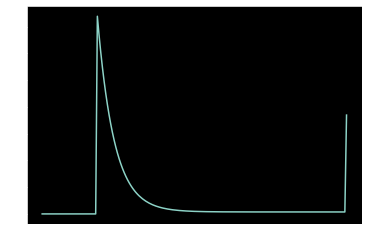

In [592]:

weight = np.zeros_like(xnn)
weight[xnn>0] = np.exp(-np.arange(np.count_nonzero(xnn>0))/10)+.01
weight[-1] = weight.max()/2

weight /= weight.sum() 
weight *= len(xnn)
plt.plot(xnn, weight)


In [647]:
history2 = mod.fit(x_train, y_train[:,None,:], validation_data=(x_test,y_test[:,None,:]), epochs=100)

Epoch 1/100
31/31 [==============================] - 16s 509ms/step - loss: 1914.1957 - val_loss: 2344.1135
Epoch 2/100
31/31 [==============================] - 15s 501ms/step - loss: 1921.3938 - val_loss: 2348.8230
Epoch 3/100
31/31 [==============================] - 16s 500ms/step - loss: 1909.4857 - val_loss: 2344.5110
Epoch 4/100
31/31 [==============================] - 15s 486ms/step - loss: 1883.8741 - val_loss: 2367.7429
Epoch 5/100
31/31 [==============================] - 15s 488ms/step - loss: 1905.9857 - val_loss: 2351.5332
Epoch 6/100
31/31 [==============================] - 20s 638ms/step - loss: 1856.7080 - val_loss: 2368.4622
Epoch 7/100
31/31 [==============================] - 25s 817ms/step - loss: 1900.1649 - val_loss: 2339.7019
Epoch 8/100
31/31 [==============================] - 24s 795ms/step - loss: 1850.1903 - val_loss: 2322.3044
Epoch 9/100
31/31 [==============================] - 24s 790ms/step - loss: 1820.9852 - val_loss: 2373.0549
Epoch 10/100
31/31 [========

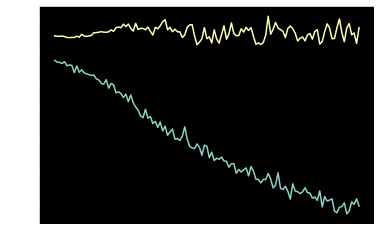

In [648]:
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.plot([*history.history['loss'], *history2.history['loss']])
plt.plot([*history.history['val_loss'], *history2.history['val_loss']])

In [649]:
res = mod.predict(x_test)
res.shape
# res = np.asarray([mod.predict(x_test[:,:(t+1),:], verbose=0) for t in range(183)])
# res.shape

res_i = np.moveaxis(np.asarray([mod.predict(x_test[:,t,None,:], verbose=0) for t in range(183)]).squeeze(),0,1)

# res_ii = 


8/8 [==============================] - 1s 166ms/step


In [630]:
res.shape, res_i.shape

# print(x_test[:,40,None,:].shape)
# print(np.tile(x_test[:,40,None,:], (1,183,1)).shape)
# print(np.tile(x_test[:,:,None,:].reshape(-1,1,170),(1,183,1)).shape)
res_ii = mod.predict(np.tile(x_test[:,:,None,:].reshape(-1,1,170),(1,183,1)))[:,-1,:].reshape(245,183,2)

print(res.shape, res_i.shape, res_ii.shape)


1402/1402 [==============================] - 298s 212ms/step
(245, 183, 2) (245, 183, 2) (245, 183, 2)


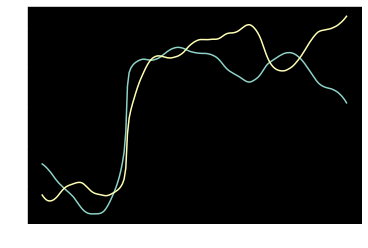

In [631]:
plt.plot(res_ii[150])

In [652]:
_,l_test = np.unique(y_test, axis=0, return_inverse=True)

inf = info.MI(l_test, ndims=2)
MI_t = np.asarray([inf.QE(res[:,t], nsamps=10) for t in range(183)])

MI_it = np.asarray([inf.QE(res_i[:,t], nsamps=10) for t in range(183)])


In [636]:
MI_iit = np.asarray([inf.QE(res_ii[:,t], nsamps=10) for t in range(183)])

In [559]:
from matplotlib.patches import Ellipse
from scipy.stats import chi2

# import matplotlib.transforms as transforms

def draw_ci(pred, l, alpha = .95 ):
    #pred is N-by-2
    li = len(np.unique(l))
    c = plt.cm.tab20(np.arange(li))
    # c = plt.cm.tab20(np.linspace(0,20,li))

    
    cl = chi2.isf(1 - alpha, 2)

    ellipses = []
    for i in range(li):
        cov = np.cov(pred[l==i,0], pred[l==i,1])
        w, v = np.linalg.eig(cov)
    
        ww = 2 * np.sqrt(cl * w)

        theta = np.arctan2(v[1,0], v[0,0])

        ellipses.append(Ellipse(pred[l==i,:].mean(axis=0), width=ww[0], height=ww[1], angle = theta, facecolor='None', edgecolor=c[i]))
    return ellipses
    

MovieWriter ffmpeg unavailable; using Pillow instead.


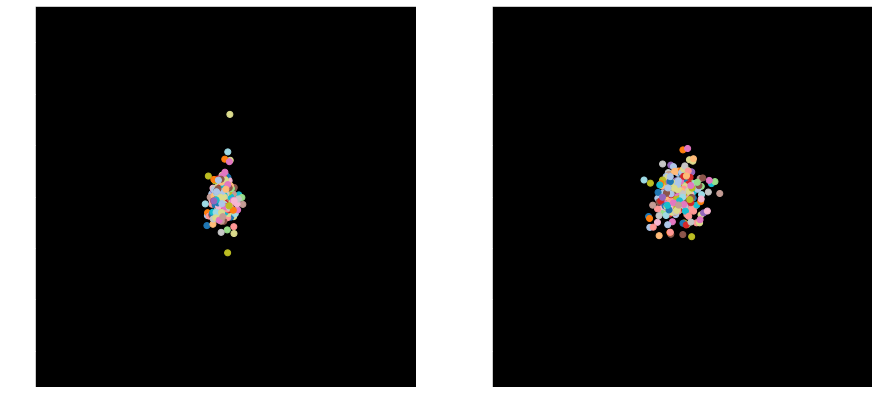

In [651]:
fig,axs = plt.subplots(1,2,figsize=(15,7))
# l_test

sc0 = axs[0].scatter(*res_ii[:,0].T, c=l_test, cmap='tab20')
axs[0].set_xlim(-37,37)
axs[0].set_ylim(-37,37)

sc1 = axs[1].scatter(*res[:,0].T, c=l_test, cmap='tab20')
axs[1].set_xlim(-37,37)
axs[1].set_ylim(-37,37)

def anim(t):
    if t<183:
        sc0.set_offsets(np.c_[res_i[:,t,0], res_ii[:,t,1]])
        sc1.set_offsets(np.c_[res[:,t,0], res[:,t,1]])
    ## by request...
    # elif t<200:
    #     sc0.set_offsets(np.c_[res_i[:,-1,0], res_i[:,-1,1]])
    #     sc1.set_offsets(np.c_[res[:,-1,0], res[:,-1,1]])
    # elif t<(200+183):
        # sc0.set_offsets(np.c_[res_i[:,199-t,0], res_i[:,199-t,1]])
        # sc1.set_offsets(np.c_[res[:,199-t,0], res[:,199-t,1]])
    else:
        sc0.set_offsets(np.c_[res_i[:,182-t,0], res_ii[:,182-t,1]])
        sc1.set_offsets(np.c_[res[:,182-t,0], res[:,182-t,1]])
    #     sc0.set_offsets(np.c_[res_i[:,0,0], res_i[:,0,1]])
    #     sc1.set_offsets(np.c_[res[:,0,0], res[:,0,1]])

    return [sc0,sc1]

animation.FuncAnimation(fig, anim, frames=183*2-1, interval=20, blit=True).save('081122B_lstm1_sng_cml.gif', fps=30)


2.958566615703349 0.9620276313219833 0.20226130653266333 0.7238149264247097


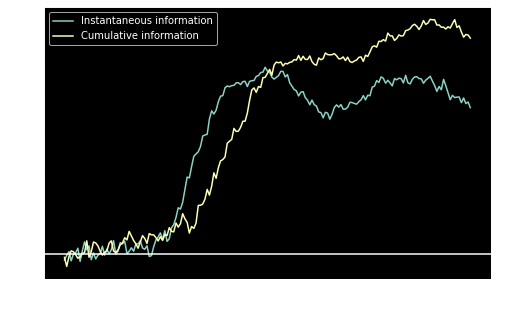

In [653]:
# plt.plot(MI_t)

plt.figure(figsize=(8,5))
plt.plot(xnn,MI_it)
# plt.plot(xnn,MI_iit)
plt.plot(xnn,MI_t)


ylim = plt.ylim()
plt.ylabel('Information (bits)')
plt.xlabel('Time (s)')


plt.legend(['Instantaneous information', 'Instantaneous information (compounded)', 'Cumulative information'],facecolor='inherit')
plt.legend(['Instantaneous information', 'Cumulative information'],facecolor='inherit')


plt.axhline(0,0,1,color='w')

plt.gca().twinx()
plt.ylim(ylim / np.log2(17) * 100)
plt.ylabel('Information (% max.)')

print(max(MI_t), max(MI_it[xnn>0] - MI_t[xnn>0]), xnn[xnn>0][np.argmax(MI_it[xnn>0] - MI_t[xnn>0])], max(MI_t)/np.log2(17))

# plt.title('Cumulative Information')


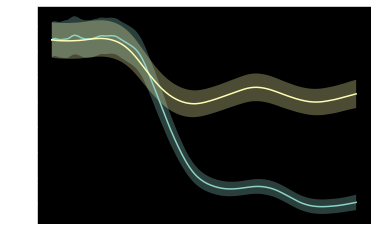

In [650]:
# plt.scatter(ue[:,0],ue[:,1])
# plt.scatter(ue[:,0] + (24.74181249*2 + 8.24727083),ue[:,1])
# plt.scatter(ue[:,0] - (24.74181249*2 + 8.24727083),ue[:,1])
# plt.scatter(ue[:,0] ,ue[:,1] - (28.56938421*2 + 14.28469211))
# plt.scatter(ue[:,0] ,ue[:,1] + (28.56938421*2 + 14.28469211))

def rms(y_true, y_pred):
    ae = np.abs(np.stack((
        y_true - y_pred,
        np.add(y_true, np.asarray([24.74181249*2 + 8.24727083, 0])) - y_pred,
        np.add(y_true, -np.asarray([24.74181249*2 + 8.24727083, 0])) - y_pred,
        np.add(y_true, np.asarray([0, 28.56938421*2 + 14.28469211])) - y_pred,
        np.add(y_true, -np.asarray([0, 28.56938421*2 + 14.28469211])) - y_pred,        
    ), axis=-1)).min(axis=-1)

    se = (ae ** 2).sum(axis=-1)
    return np.sqrt(se)

rms_e = rms(res, y_test[:,None,:])
se = rms_e.std(axis=0) * 3 / np.sqrt(rms_e.shape[0])
plt.plot(xnn, rms_e.mean(axis=0))
plt.fill_between(xnn, rms_e.mean(axis=0) + se, rms_e.mean(axis=0) - se, alpha=.3)

rms_e = rms(res_i, y_test[:,None,:])
se = rms_e.std(axis=0) * 3 / np.sqrt(rms_e.shape[0])
plt.plot(xnn, rms_e.mean(axis=0))
plt.fill_between(xnn, rms_e.mean(axis=0) + se, rms_e.mean(axis=0) - se, alpha=.3)

# rms_e = rms(res_ii, y_test[:,None,:])
# se = rms_e.std(axis=0) * 3 / np.sqrt(rms_e.shape[0])
# plt.plot(xnn, rms_e.mean(axis=0))
# plt.fill_between(xnn, rms_e.mean(axis=0) + se, rms_e.mean(axis=0) - se, alpha=.3)



3.691807306676148 0.44409839925016037 0.1834170854271357 0.9032026589743476


(0.05, 0.25)

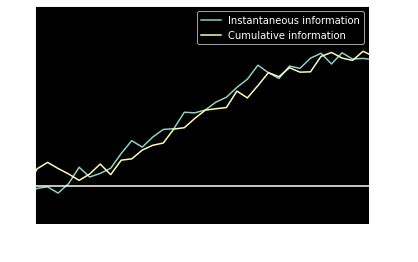

In [498]:
# plt.plot(MI_t)
plt.plot(xnn,MI_it)
plt.plot(xnn,MI_t)


ylim = plt.ylim()
plt.ylabel('Information (bits)')
plt.xlabel('Time (s)')


plt.legend(['Instantaneous information', 'Cumulative information'],facecolor='inherit')


plt.axhline(0,0,1,color='w')

plt.gca().twinx()
plt.ylim(ylim / np.log2(17) * 100)
plt.ylabel('Information (% max.)')

print(max(MI_t), max(MI_it[xnn>0] - MI_t[xnn>0]), xnn[xnn>0][np.argmax(MI_it[xnn>0] - MI_t[xnn>0])], max(MI_t)/np.log2(17))

# plt.title('Cumulative Information')

plt.xlim(.05,.25)


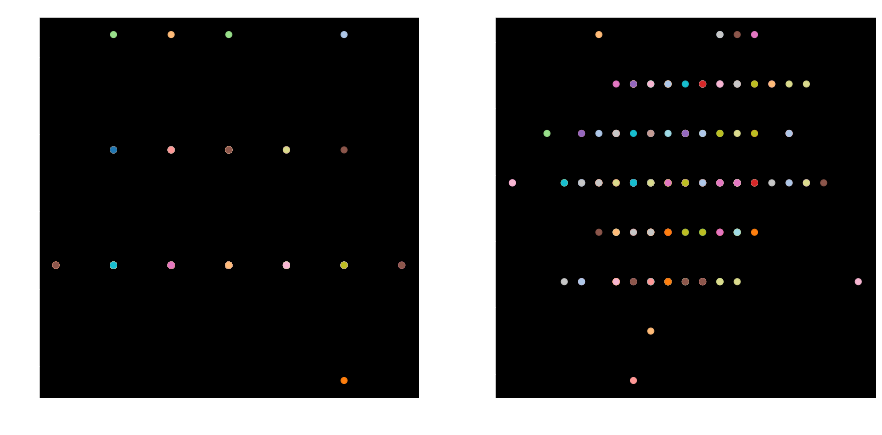

In [539]:
t = 35
scale = 1


fig,axs = plt.subplots(1,2,figsize=(15,7))
# l_test

sc0 = axs[0].scatter(*res_i[:,t].T * scale, c=l_test, cmap='tab20')
# axs[0].set_xlim(-37,37)
# axs[0].set_ylim(-37,37)

sc1 = axs[1].scatter(*res[:,t].T * scale, c=l_test, cmap='tab20')
# axs[1].set_xlim(-37,37)
# axs[1].set_ylim(-37,37)


In [469]:
def do_cv(xdata, ydata, yindex, seed = 0):
    cv = KFold(5, shuffle=True, random_state=seed)

    ns, nt, nf = xdata.shape

    yhat_c = np.zeros((ns,nt,2))
    yhat_i = np.zeros((ns,nt,2))
    mods = []
    histories = []

    for train, test in cv.split(xdata):
        mod = keras.Sequential()
        mod.add(layers.Input((None,nf)))
        mod.add(layers.Normalization())
        mod.add(layers.SpatialDropout1D(.25))
        mod.add(layers.LSTM(128, dropout=.3, recurrent_dropout=.1, kernel_regularizer='l1', recurrent_regularizer='l1', return_sequences=True))
        mod.add(layers.TimeDistributed(layers.Dense(16)))
        mod.add(layers.TimeDistributed(layers.Dense(2)))
        # mod.summary

        mod.compile(loss=keras.losses.MeanSquaredError())
        history = mod.fit(xdata[train], ydata[yindex[train],None,:], validation_data=(xdata[test], ydata[yindex[test],None,:]), epochs=150)

        yhat_c[test,:,:] = mod.predict(xdata[test])
        yhat_i[test,:,:] = np.moveaxis(np.asarray([mod.predict(xdata[test,t,None,:], verbose=0) for t in range(nt)]).squeeze(),0,1)

        # _,l_test = np.unique(y_test, axis=0, return_inverse=True)

        # inf = info.MI(yindex[test], ndims=2)

        # yhat[test,:] = np.asarray([inf.QE(res_c[:,t]) for t in range(nt)])
        # yhat[test,:] = np.asarray([inf.QE(res_i[:,t]) for t in range(nt)])

        mods.append(mod)
        histories.append(history)
    return yhat_c,yhat_i, mods, histories

In [470]:
yhat_c, yhat_i, mods, histories = do_cv(np.moveaxis(data,-1,-2), ue, labels)

Epoch 1/150
31/31 [==============================] - 12s 334ms/step - loss: 322.1284 - val_loss: 290.2462
Epoch 2/150
31/31 [==============================] - 11s 356ms/step - loss: 266.4250 - val_loss: 231.0685
Epoch 3/150
31/31 [==============================] - 11s 350ms/step - loss: 228.1837 - val_loss: 200.1216
Epoch 4/150
31/31 [==============================] - 10s 324ms/step - loss: 205.2898 - val_loss: 209.3999
Epoch 5/150
31/31 [==============================] - 10s 335ms/step - loss: 195.0692 - val_loss: 205.4937
Epoch 6/150
31/31 [==============================] - 10s 323ms/step - loss: 186.4509 - val_loss: 189.0585
Epoch 7/150
31/31 [==============================] - 10s 335ms/step - loss: 181.9822 - val_loss: 173.7370
Epoch 8/150
31/31 [==============================] - 10s 332ms/step - loss: 177.0930 - val_loss: 162.5652
Epoch 9/150
31/31 [==============================] - 10s 332ms/step - loss: 175.3368 - val_loss: 166.6938
Epoch 10/150
31/31 [==========================

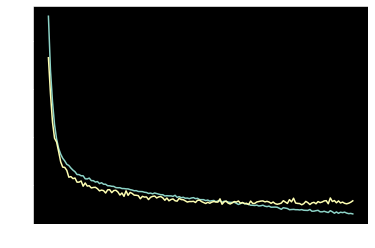

In [471]:
plt.plot(np.asarray([histories[i].history['loss'] for i in range(5)]).mean(axis=0))
plt.plot(np.asarray([histories[i].history['val_loss'] for i in range(5)]).mean(axis=0))



In [472]:
inf = info.MI(labels, ndims=2)
MI_c = np.asarray([inf.QE(yhat_c[:,t]) for t in range(183)])
MI_i = np.asarray([inf.QE(yhat_i[:,t]) for t in range(183)])

3.205038282857367 0.6104993011559177 0.14572864321608042 0.7841143534107231


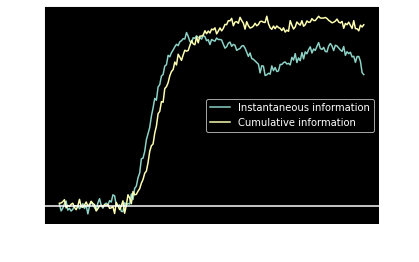

In [473]:
# plt.plot(MI_t)
plt.plot(xnn,MI_i)
plt.plot(xnn,MI_c)


ylim = plt.ylim()
plt.ylabel('Information (bits)')
plt.xlabel('Time (s)')


plt.legend(['Instantaneous information', 'Cumulative information'],facecolor='inherit')


plt.axhline(0,0,1,color='w')

plt.gca().twinx()
plt.ylim(ylim / np.log2(17) * 100)
plt.ylabel('Information (% max.)')

print(max(MI_c), max(MI_i[xnn>0] - MI_c[xnn>0]), xnn[xnn>0][np.argmax(MI_i[xnn>0] - MI_c[xnn>0])], max(MI_c)/np.log2(17))

# plt.title('Cumulative Information')


In [476]:
yhat_i.shape

(1222, 183, 2)

MovieWriter ffmpeg unavailable; using Pillow instead.


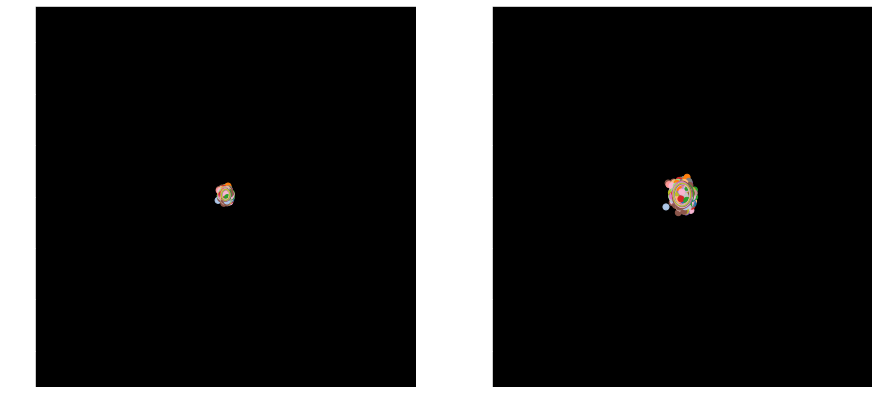

In [560]:
fig,axs = plt.subplots(1,2,figsize=(15,7))
# l_test

li = len(np.unique(labels))
c = plt.cm.tab20(np.arange(li))
    

sc0 = axs[0].scatter(*yhat_i[:,-1].T, c=c[labels], cmap='tab20')
axs[0].set_xlim(-37,37)
axs[0].set_ylim(-37,37)

sc1 = axs[1].scatter(*yhat_c[:,-1].T, c=c[labels], cmap='tab20')
axs[1].set_xlim(-37,37)
axs[1].set_ylim(-37,37)

es_i = draw_ci(yhat_i[:,-1], labels, alpha=.9)
for e in es_i:
    axs[0].add_patch(e) 

es_c = draw_ci(yhat_c[:,-1], labels, alpha=.9)
for e in es_c:
    axs[1].add_patch(e) 

def anim(t):
    global es_i, es_c
    if t<183:
        tt = t
    else:
        tt = 182-t
    
    sc0.set_offsets(np.c_[yhat_i[:,tt,0], yhat_i[:,tt,1]])
    sc1.set_offsets(np.c_[yhat_c[:,tt,0], yhat_c[:,tt,1]])

    new_i = draw_ci(yhat_i[:,tt], labels, alpha=.9)
    for old,new in zip(es_i, new_i):
        old.remove()
        axs[0].add_patch(new)
    es_i = new_i

    new_c = draw_ci(yhat_c[:,tt], labels, alpha=.9)
    for old,new in zip(es_c, new_c):
        old.remove()
        axs[1].add_patch(new)
    es_c = new_c

    return [sc0,sc1]

animation.FuncAnimation(fig, anim, frames=183*2-1, interval=20, blit=True).save('081122B_lstm2_sng_cml.gif', fps=30)